In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import log_loss, roc_auc_score

import matplotlib.pyplot as plt
import os

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Первая часть ноутбука с обработкой данных делалась на колабе. `xlearn` почему-то отказывался работь, поэтому пришлось досчитывать на ноуте...

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# PATH = '/content/drive/MyDrive/HSE/RecSys'
PATH = '../../data'

In [4]:
%%time
df = pd.read_csv(os.path.join(PATH,'data.csv'))
df.drop(['banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'], axis=1, inplace=True)
df.head()

CPU times: user 37.5 s, sys: 10.2 s, total: 47.7 s
Wall time: 53.2 s


,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,1,1


In [5]:
def analysis(df: pd.DataFrame):
    # посчитаем количество NaN в стобцах
    print(f'Чисто NaN в данных: {df.isna().sum().sum()}', '\n')
    
    print('Посчитаем количество уникальных признаков в каждом столбце:')
    for name in df.columns.values[1:-1]:
       print(name.ljust(20), df[name].nunique())
    print()

    print('построим график для campaign_clicks:')
    plt.hist(df['campaign_clicks'], bins=200)
    plt.title('campaign_clicks')
    plt.yscale('log')
    plt.show()
    print()

    oaid_hash = df['oaid_hash']
    oaid_counts = pd.value_counts(oaid_hash)
    pd.value_counts(oaid_counts)[:5].sum()
    print(f'Количество юзеров с числом посещений >= 5: {pd.value_counts(oaid_counts)[5:].sum()}')
    print(f'Есть ли среди хешей значение ноль: {(oaid_hash == 0).any()}')


    plt.hist(oaid_counts[oaid_counts<1000], bins=100)
    plt.title('value_counts oaid_hash')
    plt.yscale('log')
    plt.xlabel('число посещений')
    plt.ylabel('число юзеров')
    plt.show()

    print('посмотрим на распределение дней:')
    days = df.date_time.apply(lambda x: x[:10])
    days_counts = days.value_counts()
    print(days_counts.sort_index(), '\n')

    

Чисто NaN в данных: 0 

Посчитаем количество уникальных признаков в каждом столбце:
zone_id              3444
banner_id            1633
oaid_hash            6510316
campaign_clicks      822
os_id                11
country_id           17
impressions          1

построим график для campaign_clicks:


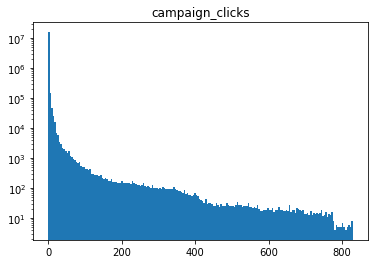


Количество юзеров с числом посещений >= 5: 468521
Есть ли среди хешей значение ноль: False


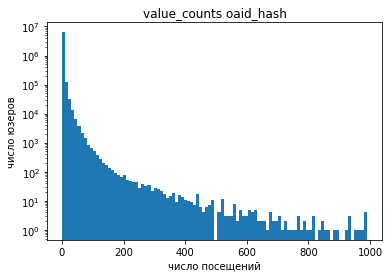

посмотрим на распределение дней:
2021-09-01          1
2021-09-26    3102610
2021-09-27    2367303
2021-09-28    2307355
2021-09-29    2420588
2021-09-30    1851189
2021-10-01    1643448
2021-10-02    2128978
Name: date_time, dtype: int64 

CPU times: user 13.7 s, sys: 1.02 s, total: 14.7 s
Wall time: 14.7 s


In [6]:
%%time
analysis(df)

Выводы по данным (из HW1):
* В данных нет NaN-ов
* В данных есть колонка `impressions`, у которой одно значение, она не вносит никакого вклада, ее уберем
* Среди `date_time` есть день с одной записью, по самим данным он не выглядит как что-то из ряда вон выходящее, поэтому его можно оставить, хотя его существование овеяно тайной и загадкой :)
* Дни по сути представлены одной неделей, в ответе нам надо предоставить результаты для `2021-10-02`.
* Я думаю, что вводить признак дня недели тоже имеет смысл, но я не буду этого делать, потому что в тесте день недели, который не попадает в тест, и этот признак не сможем проверить. При прочих равных этот признак я бы добавил.
* Добавим в качестве признака время просмотра рекламы. Эта фича может быть полезной. 
* Признак `campaign_clicks` числовой, его можно использовать, однако он распределен очень несимметрично, поэтому логарифмируем его (с небольшой регуляризацией, потому что у нас есть там нули и не хочется разбираться с NaN).

Новые выводы:
* Признак `oaid_hash` показывает id юзеров. Видно, что только 460к из 6.5м пользователей видели рекламу не менее 5 раз. Поэтому для уменьшения количества параметров модели дадим юзерам, видевшим рекламу меньше 5 раз, одинаковый хеш.




In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    # добавим признак времени
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['hour'] = df['date_time'].dt.hour

    # присвоим юзерам, у которых меньше 5 посещений, одинаковое значение хэша - пусть будет ноль
    oaid_hash = df['oaid_hash']
    oaid_counts = pd.value_counts(oaid_hash)
    idxs = oaid_hash.isin(oaid_counts[oaid_counts < 5].index)
    df['oaid_hash'][idxs] = 0

    # преобразуем campaign_clicks и дропнем ненужные столбцы из таблицы, разделим на train, val и test
    df['campaign_clicks'] = np.log(df['campaign_clicks']+0.1)
    idx_train = df['date_time'] < pd.to_datetime('2021-10-02')
    df.drop(['date_time', 'impressions'], axis=1, inplace=True)
    
    X_train = df[idx_train]
    X_train, X_val = train_test_split(X_train, test_size=0.2)
    X_test = df[~idx_train]

    return X_train, X_val, X_test

In [9]:
%%time
X_train, X_val, X_test = feature_engineering(df)

print(f'Число записей в train: {X_train.shape[0]}')
print(f'Число записей в test : {X_test.shape[0]}')
print(f'Число признаков: {X_train.shape[1]}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Число записей в train: 10953995
Число записей в test : 2128978
Число признаков: 8
CPU times: user 16.1 s, sys: 794 ms, total: 16.9 s
Wall time: 16.9 s


In [ ]:
X_val.shape[0]

In [ ]:
with open(os.path.join(PATH, 'y_test.npy'), 'wb') as f:
    np.save(f, X_test.clicks.to_numpy())

Чтобы воспользоваться реализацией `FFM` в `xlearn`, данные надо привети к специальному формату. Я нашел репозиторий, в котором были представлены необходимые скрипты с примерами использования.

https://github.com/wngaw/blog/blob/master/xlearn_example/src/utils.py
https://github.com/wngaw/blog/blob/master/xlearn_example/src/task_xl_ffm.py

In [ ]:
from tqdm import tqdm
import math

def _convert_to_ffm(path, df, type, target, numerics, categories, features, encoder):
    # Flagging categorical and numerical fields
    print('convert_to_ffm - START')
    for x in numerics:
        if(x not in encoder['catdict']):
            print(f'UPDATING CATDICT: numeric field - {x}')
            encoder['catdict'][x] = 0
    for x in categories:
        if(x not in encoder['catdict']):
            print(f'UPDATING CATDICT: categorical field - {x}')
            encoder['catdict'][x] = 1

    nrows = df.shape[0]
    with open(os.path.join(path, str(type) + "_ffm.txt"), "w") as text_file:

        # Looping over rows to convert each row to libffm format
        for n, r in tqdm(enumerate(range(nrows)), "Formatting", nrows):
            datastring = ""
            datarow = df.iloc[r].to_dict()
            datastring += str(int(datarow[target]))  # Set Target Variable here

            # For numerical fields, we are creating a dummy field here
            for i, x in enumerate(encoder['catdict'].keys()):
                if(encoder['catdict'][x] == 0):
                    # Not adding numerical values that are nan
                    if math.isnan(datarow[x]) is not True:
                        datastring = datastring + " "+str(i)+":" + str(i)+":" + str(datarow[x])
                else:

                    # For a new field appearing in a training example
                    if(x not in encoder['catcodes']):
                        #print(f'UPDATING CATCODES: categorical field - {x}')
                        encoder['catcodes'][x] = {}
                        encoder['currentcode'] += 1
                        # print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    # For already encoded fields
                    elif(datarow[x] not in encoder['catcodes'][x]):
                        encoder['currentcode'] += 1
                        #print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    code = encoder['catcodes'][x][datarow[x]]
                    datastring = datastring + " "+str(i)+":" + str(int(code))+":1"

            datastring += '\n'
            text_file.write(datastring)
    return encoder


Зададим параметры, как в примерах

In [13]:
GOAL = ['clicks']
NUMERICAL_FEATURES = ['campaign_clicks']
CATEGORICAL_FEATURES = ['zone_id','banner_id','oaid_hash','country_id', 'os_id']
ALL_FEATURES = ['zone_id','banner_id','oaid_hash','campaign_clicks','country_id', 'os_id']

In [14]:
encoder = {"currentcode": len(NUMERICAL_FEATURES),
           "catdict": {},
           "catcodes": {}}

Преобразуем данные

In [ ]:
encoder = _convert_to_ffm(PATH, X_train, 'X_train', GOAL[0],
                          NUMERICAL_FEATURES,
                          CATEGORICAL_FEATURES,
                          ALL_FEATURES,
                          encoder)

convert_to_ffm - START
UPDATING CATDICT: numeric field - campaign_clicks
UPDATING CATDICT: categorical field - zone_id
UPDATING CATDICT: categorical field - banner_id
UPDATING CATDICT: categorical field - oaid_hash
UPDATING CATDICT: categorical field - os_id
UPDATING CATDICT: categorical field - country_id


Formatting: 100%|██████████| 10953995/10953995 [30:24<00:00, 6004.94it/s]


In [ ]:
encoder = _convert_to_ffm(PATH, X_val, 'X_val', GOAL[0],
                          NUMERICAL_FEATURES,
                          CATEGORICAL_FEATURES,
                          ALL_FEATURES,
                          encoder)

convert_to_ffm - START
UPDATING CATDICT: numeric field - campaign_clicks
UPDATING CATDICT: categorical field - zone_id
UPDATING CATDICT: categorical field - banner_id
UPDATING CATDICT: categorical field - oaid_hash
UPDATING CATDICT: categorical field - os_id
UPDATING CATDICT: categorical field - country_id


Formatting: 100%|██████████| 2738499/2738499 [08:18<00:00, 5488.35it/s]


In [ ]:
encoder = _convert_to_ffm(PATH, X_test, 'X_test', GOAL[0],
                          NUMERICAL_FEATURES,
                          CATEGORICAL_FEATURES,
                          ALL_FEATURES,
                          encoder)

convert_to_ffm - START
UPDATING CATDICT: numeric field - campaign_clicks
UPDATING CATDICT: categorical field - zone_id
UPDATING CATDICT: categorical field - banner_id
UPDATING CATDICT: categorical field - oaid_hash
UPDATING CATDICT: categorical field - os_id
UPDATING CATDICT: categorical field - country_id


Formatting: 100%|██████████| 2128978/2128978 [05:54<00:00, 6000.70it/s]


# Обучим модельку


In [4]:
import xlearn as xl

Дальше бучать будем на ноутбуке. К сожалению, оперативки мало и если учить модель больше 2 раз подряд, то все намертво виснет. Поэтому гиперпараметры не получается нормально перебрать, обучим хоть как-нибудь

In [7]:
ffm_model = xl.create_ffm()
ffm_model.setTrain(os.path.join(PATH, 'X_train_ffm.txt'))
ffm_model.setValidate(os.path.join(PATH, 'X_val_ffm.txt'))
param = {'task':'binary',
        'lr':0.01, 
        'lambda':0.00001, 
        'metric': 'auc', 
        'epoch':20, 
        'k': 4}

# ffm_model.disableEarlyStop()
ffm_model.fit(param, "model.out")

ffm_model.setTest(os.path.join(PATH, 'X_test_ffm.txt'))
ffm_model.setSigmoid()
ffm_model.predict("model.out", "output.txt")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 4 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (../../data/X_train_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (../../data/X_val_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 580054
[------------] Number of Field: 6
[------------] Time cost for reading problem: 29.9

In [8]:
with open(os.path.join(PATH, 'y_test.npy'), 'rb') as f:
    y_test = np.load(f)

y_pred = np.genfromtxt('output.txt', dtype=float)

loss = log_loss(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)
print(f"Log loss: {loss:.3f}, roc-auc: {roc_score:.3f}")

Log loss: 0.150, roc-auc: 0.657


У линейной модели в прошлой домашке были значения:
$$\text{Log loss}: 0.136, \text{ roc-auc}: 0.768$$

У бейзлайна:
$$\text{Log loss}: 0.154, \text{ roc-auc}: 0.5$$

Видно, что наш FFM обучился не очень хорошо, у линейной модели ощутимо меньше Log loss и больше roc-auc, и вообще метрики очень близки к бейзлайну (хотя до этого несколько лучше...). Я думаю, что если поподбирать параметры, то можно сильно улучшить результат, но у меня не хватает вычислительных мощностей.